#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

## Подготовка

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Datetime

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [7]:
data = data.set_index('datetime')
data.sample(5)

,num_orders
datetime,
2018-06-06 08:00:00,19
2018-07-27 22:50:00,33
2018-03-08 10:10:00,8
2018-08-29 21:50:00,36
2018-04-02 03:40:00,11


In [8]:
data.index.is_monotonic

True

In [9]:
data = data.resample('1H').sum()
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные готовы для анализа

## Анализ

### Сырые данные

Дла начала построим график в "сыром" виде

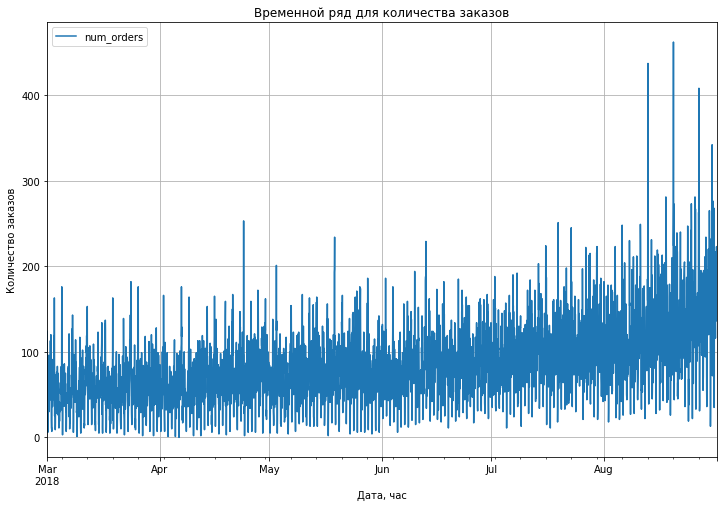

In [10]:
data.plot(grid=True, figsize=(12, 8))
plt.ylabel('Количество заказов')
plt.xlabel('Дата, час')
plt.title('Временной ряд для количества заказов');

### Скользящее среднее

Рассмотрим скользящее среднее и стандартное отклонение

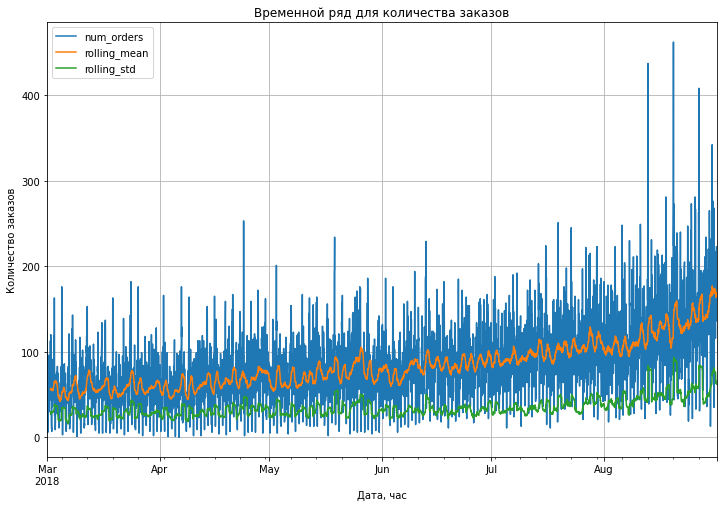

In [11]:
data['rolling_mean'] = data.rolling(24).mean()
data['rolling_std'] = data['num_orders'].rolling(24).std()
data.plot(grid=True, figsize=(12, 8))
plt.ylabel('Количество заказов')
plt.xlabel('Дата, час')
plt.title('Временной ряд для количества заказов');

Происходит рост числа заказов со временем. Изучим тренд и сезонность

### Сезонность и тренд

In [12]:
def decompose(data):
    decomposition = seasonal_decompose(data)
    
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    decomposition.trend.plot(ax=plt.gca())
    plt.grid(True)
    plt.ylabel('Количество заказов')
    plt.title('Тренд')
    
    
    plt.subplot(3, 1, 2)
    decomposition.seasonal.plot(ax=plt.gca())
    plt.grid(True)
    plt.title('Сезонность')
    
    plt.subplot(3, 1, 3)
    decomposition.resid.plot(ax=plt.gca())
    plt.grid(True)
    plt.title('Шум')
    
    plt.xlabel('Дата, час')
    
    plt.show()
    
    return decomposition

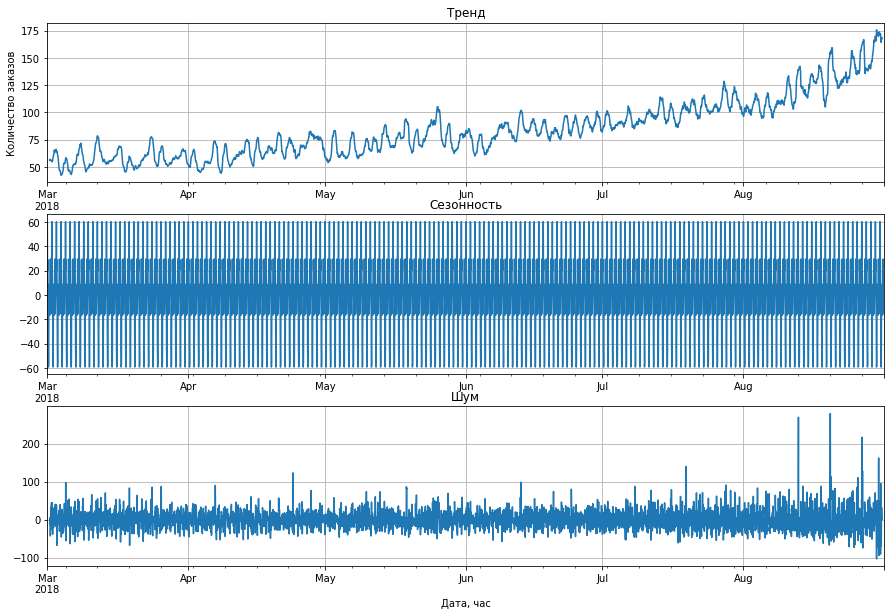

In [13]:
decomposition = decompose(data['num_orders'])

Тренд идет вверх. Сезонность необходимо рассмотреть более детально

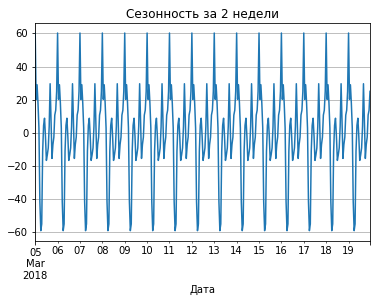

In [14]:
decomposition.seasonal['2018-03-05':'2018-03-19'].plot(grid=True)
plt.xlabel('Дата')
plt.title('Сезонность за 2 недели');

В течении недели особых изменений не наблюдается

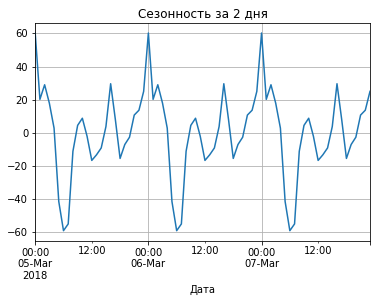

In [15]:
decomposition.seasonal['2018-03-05':'2018-03-07'].plot(grid=True)
plt.xlabel('Дата')
plt.title('Сезонность за 2 дня');

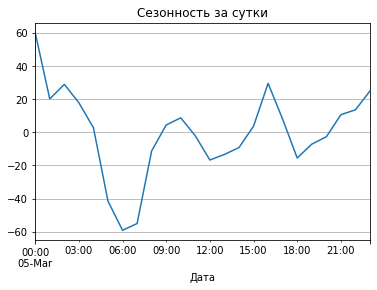

In [16]:
decomposition.seasonal['2018-03-05':'2018-03-05'].plot(grid=True)
plt.xlabel('Дата')
plt.title('Сезонность за сутки');

Чаще всего такси заказывают в районе полуночи. Меньше всего - в 6 ночи. Утром все едут на работу, а в районе 17 часов возвращаются, поэтому частота поездок примерно одинаковая

Рассмотрим декомпозицию при ресемплинге по дням

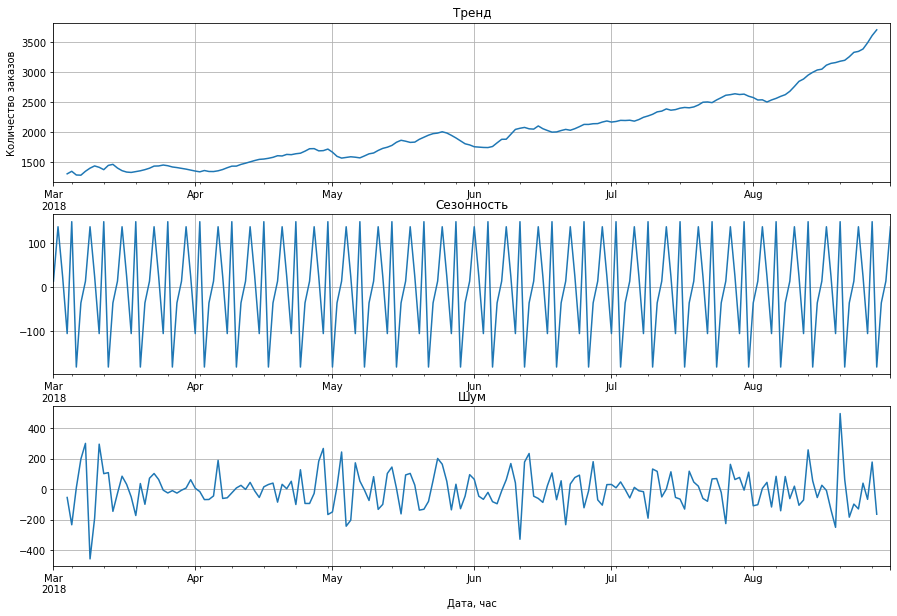

In [17]:
decomposition = decompose(data.resample('1D').sum()['num_orders'])

In [18]:
decomposition.seasonal['2018-03-05':'2018-03-06'].index.dayofweek

Int64Index([0, 1], dtype='int64', name='datetime')

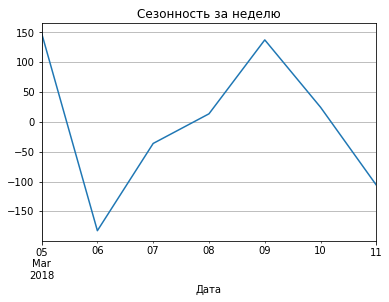

In [19]:
decomposition.seasonal['2018-03-05':'2018-03-11'].plot(grid=True)
plt.xlabel('Дата')
plt.title('Сезонность за неделю');

Наблюдаем периодичность и в течении недели. Во вторник меньше всего заказов. Больше всего в понедельник и пятницу

### Разность временного ряда

Рассмотрим разность временного ряда

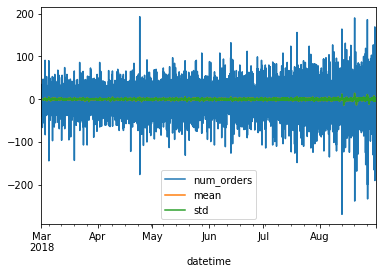

In [20]:
diff = pd.DataFrame(data = data['num_orders'] - data['num_orders'].shift(), index=data.index)
diff['mean'] = diff.rolling(24).mean()
diff['std'] = diff['num_orders'].rolling(24).mean()
diff.plot();

Разность стационарна. Значит, изменение временного ряда не меняется со временем => мы способны делать адекватные предсказания

## Обучение

### Создание признаков

Создадим признаки для датасета. Ежечасное, еждневное и ежемесячное изменение данных играет роль. Также важен день недели. Создадим столбцы лага, а так же скользящего среднего

In [21]:
def create_dataset(max_lag, window):
    dataset = pd.DataFrame(data=data['num_orders'], index=data.index)
    dataset['hour'] = dataset.index.hour
    dataset['day'] = dataset.index.day
    dataset['month'] = dataset.index.month
    
    for i in range(1, max_lag+1):
        dataset[f'lag_{i}'] = dataset['num_orders'].shift(i)
    
    dataset['rolling_mean'] = dataset['num_orders'].rolling(window).mean()
    return dataset
    

В качестве лага используем половину суток (за половину суток происходят самые большие изменения). В качестве окна выберем жвое суток, так мы сможешь "отслеживать" тренд

In [22]:
dataset = create_dataset(12, 48)
dataset.sample(5)

,num_orders,hour,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,
2018-05-31 06:00:00,6,6,31,5,48.0,142.0,92.0,101.0,61.0,137.0,85.0,79.0,115.0,98.0,102.0,53.0,72.479167
2018-08-27 06:00:00,31,6,27,8,62.0,295.0,208.0,408.0,222.0,263.0,238.0,145.0,107.0,122.0,126.0,127.0,145.791667
2018-04-02 13:00:00,64,13,2,4,57.0,82.0,111.0,57.0,62.0,7.0,20.0,33.0,33.0,47.0,57.0,101.0,57.979167
2018-08-31 13:00:00,166,13,31,8,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,170.645833
2018-08-25 22:00:00,155,22,25,8,162.0,105.0,123.0,123.0,158.0,182.0,150.0,130.0,63.0,114.0,103.0,126.0,141.583333


### Разделение на выборки

In [23]:
train, test = train_test_split(dataset, test_size=0.1, shuffle=False)
train = train.dropna()

In [24]:
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']

In [25]:
X_train.shape

(3927, 16)

In [26]:
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

In [27]:
X_test.shape

(442, 16)

### Обучение моделей

#### rmse

In [28]:
rmse = make_scorer(lambda x, y: np.sqrt(mean_squared_error(x, y)), greater_is_better=False)

In [29]:
time_series_split = TimeSeriesSplit(n_splits=3)

#### Dummy model

Обучим дамми модель для сравнения

In [31]:
try:
    dummy_score = cross_val_score(DummyRegressor(), X_train, y_train, scoring=rmse, cv=time_series_split)
except Exception as e:
    print("Couldn't use TimeSeriesSplit", e)
    dummy_score = cross_val_score(DummyRegressor(), X_train, y_train)
dummy_score.mean()

-42.66886165931078

#### Linear Regressor

In [32]:
linear_model_score = cross_val_score(LinearRegression(), X_train, y_train, cv=time_series_split, scoring=rmse)

In [33]:
linear_model_score.mean()

-32.043324119948615

#### Decision Tree

In [34]:
params = {'max_depth': range(1, 25)}

In [35]:
%%time

tree_model = GridSearchCV(DecisionTreeRegressor(), param_grid=params, cv=time_series_split, scoring=rmse).fit(X_train, y_train)

CPU times: user 1.54 s, sys: 116 µs, total: 1.54 s
Wall time: 1.54 s


In [36]:
tree_model.best_score_

-33.5788104282959

In [37]:
tree_model.best_params_

{'max_depth': 4}

#### Forest

In [38]:
params = {'max_depth': range(5, 15), 'n_estimators': range(50, 201, 50)}

In [39]:
%%time

forest_model = GridSearchCV(RandomForestRegressor(),
                            param_grid=params,
                            cv=time_series_split,
                            scoring=rmse).fit(X_train, y_train)

CPU times: user 2min 41s, sys: 747 ms, total: 2min 42s
Wall time: 2min 42s


In [40]:
forest_model.best_score_

-26.486414732932598

In [41]:
forest_model.best_params_

{'max_depth': 14, 'n_estimators': 200}

#### Catboost

In [42]:
params = {'max_depth': range(1, 5), 'iterations': range(500, 1001, 100)}

In [43]:
%%time

boosting_model = GridSearchCV(CatBoostRegressor(verbose=False),
                              param_grid=params,
                              cv=time_series_split,
                              scoring=rmse).fit(X_train, y_train)

CPU times: user 43.5 s, sys: 4.38 s, total: 47.9 s
Wall time: 1min 44s


In [44]:
boosting_model.best_score_

-26.321346197274455

In [45]:
boosting_model.best_params_

{'iterations': 600, 'max_depth': 3}

### Итоги

In [46]:
results_table = pd.DataFrame(data=[42.7, 32.0, 33.6, 26.4, 26.3],
                             columns=['rmse score'],
                             index=['dummy', 'linear regressor', 'tree', 'forest', 'boosting'])
results_table

,rmse score
dummy,42.7
linear regressor,32.0
tree,33.6
forest,26.4
boosting,26.3


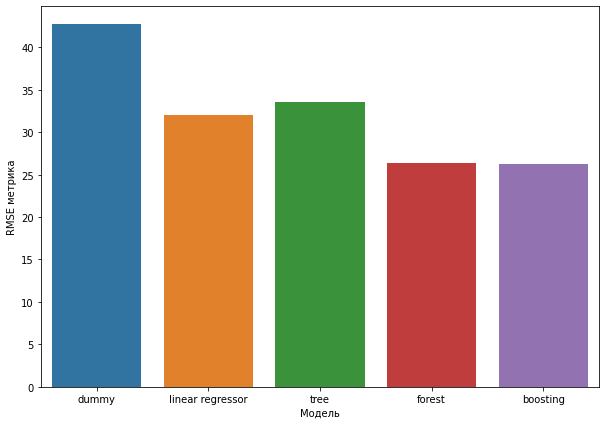

In [47]:
plt.figure(figsize=(10, 7))
sbs.barplot(x=results_table.index, y=results_table['rmse score'])
plt.xlabel('Модель')
plt.ylabel('RMSE метрика');

Лучший результат показала модель catboost

## Тестирование

Протестируем модель на тестовой выборке

In [48]:
best_model = boosting_model.best_estimator_
predictions = best_model.predict(X_test)

np.sqrt(mean_squared_error(y_test, predictions))

45.3278343549692

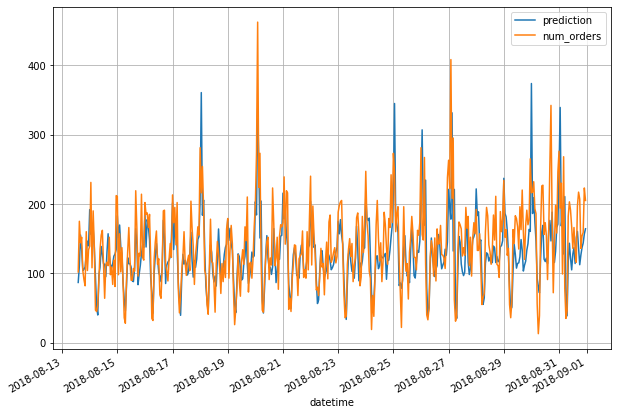

In [49]:
plt.figure(figsize=(10, 7))
plt.plot(X_test.index, predictions, label='prediction')
y_test.plot(ax=plt.gca())
plt.grid(True)
plt.legend()

RMSE ниже 48

## Выводы

В процессе работы было выполнено:
 - загрузка и предобработка данных
 - анализ данных:
  - проанализирован график "сырых" данных
  - проанализированы графики тренда и сезонности
  - проанализирован график сдвига
 - добавлены признаки для обучения
 - выбрана модель catboost
 - модель протестирована на тестовой выборке